# Tensorflow 2

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, time
import cv2
import argparse, random
import skimage.transform
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy.io

In [2]:
# tf.compat.v1.disable_eager_execution()

In [3]:
print(tf.__version__)

2.3.1


In [4]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
# Configuration
IMG_SIZE = 112
EPOCHS = 20
BATCH_SIZE = 256
BUFFER_SIZE = 1000

delta = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
delta_i = delta[-1]

PATH = os.path.abspath('.') + "/dataset/PlacePulse"
IMG_PATH = PATH + "/images/2011/"
LABEL_PATH = PATH + "/labels/"

SAVE_PATH = 'saved_model'

num_test_sample = 50
num_label = 2

In [6]:
def load_image(image_path, img_dims=[224, 224]):
    orig = load_img(image_path, target_size=img_dims)
    img = img_to_array(orig)/255.
    #img = tf.keras.applications.vgg16.preprocess_input(img)
    #img = tf.keras.applications.imagenet_utils.preprocess_input(img)
    return img, image_path

In [7]:
def load_labels(delta_i, labels_path=LABEL_PATH+"features.csv"):
    data = pd.read_csv(labels_path)
    data = data.loc[:,["ID","y"]].copy()
    slen = len(data)
    val = round(delta_i*slen)
    data["class"] = data['y']
    data['class'].iloc[:val+1]=1
    data['class'].iloc[slen-val:] = 0
    return data

data = load_labels(delta_i)
print(data[data["ID"]==4340])

     ID     y  class
0  4340  8.35    1.0


/home/jenazads/anaconda3/envs/tf2/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [8]:
all_img = np.asarray([IMG_PATH+str(img)+".jpg" for img in data.loc[:,"ID"].values.copy()])
all_labels = data.loc[:,"class"].copy()
all_scores = data.loc[:,"y"].values.copy(), 
all_features = []

for img in all_img:
  features, _ = load_image(img, img_dims=[IMG_SIZE, IMG_SIZE])
  all_features.append(features)

all_features = np.array(all_features)
all_labels = tf.keras.utils.to_categorical(all_labels, num_classes=2)

In [9]:
slen = len(data)
val = round(delta_i*slen)
X_pos = all_features[:val+1]
X_neg = all_features[slen-val:]
y_pos = all_labels[:val+1]
y_neg = all_labels[slen-val:]
img_pos = all_img[:val+1]
img_neg = all_img[slen-val:]

In [10]:
xtrain_pos, xtest_pos, ytrain_pos, ytest_pos = train_test_split(X_pos, y_pos, shuffle=True, test_size = 0.25, random_state=35)
xtrain_neg, xtest_neg, ytrain_neg, ytest_neg = train_test_split(X_neg, y_neg, shuffle=True, test_size = 0.25, random_state=35)

train_x = np.concatenate([xtrain_pos, xtrain_neg])
test_x = np.concatenate([xtest_pos, xtest_neg])

imgtrain_pos, imgtest_pos, ytrain_pos, ytest_pos = train_test_split(img_pos, y_pos, shuffle=True, test_size = 0.25, random_state=35)
imgtrain_neg, imgtest_neg, ytrain_neg, ytest_neg = train_test_split(img_neg, y_neg, shuffle=True, test_size = 0.25, random_state=35)

imgtrain_val = np.concatenate([imgtrain_pos, imgtrain_neg])
imgtest = np.concatenate([imgtest_pos, imgtest_neg])

train_y = np.float32(np.concatenate([ytrain_pos, ytrain_neg]))
test_y = np.float32(np.concatenate([ytest_pos, ytest_neg]))

print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)
print(imgtrain_val.shape, imgtest.shape)
print(np.max(train_x), np.min(train_x))
num_steps = len(imgtrain_val) // BATCH_SIZE

(927, 112, 112, 3) (310, 112, 112, 3)
(927, 2) (310, 2)
(927,) (310,)
1.0 0.0


(112, 112, 3)


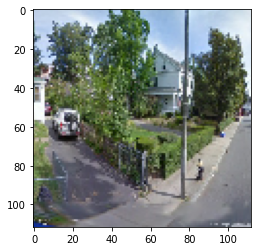

Label: [0. 1.]
Shape: 112x112


In [11]:
# Plotting example image
img = train_x[0, :, :]
print(img.shape)

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img.shape[0]) + 'x' + str(img.shape[0]))

In [12]:
def reset_state(batch_size, units):
    return tf.zeros((batch_size, units))

In [13]:
class SoftAttentionLayer(tf.keras.layers.Layer):
  def __init__(self, units, name='AttentionLayer', **kwargs):
    super(SoftAttentionLayer, self).__init__(name=name)
    self.units = units

    #super(SoftAttentionLayer, self).__init__(**kwargs)
    #self.name = name
  def build(self, input_shape):
    self.W1 = tf.keras.layers.Dense(self.units, kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
    self.W2 = tf.keras.layers.Dense(self.units, kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
    self.V = tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
    
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 196, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 196, hidden_size)
    #print("feature:", features.shape)
    #print("hidden:", hidden_with_time_axis.shape)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 196, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    #attention_weights = tf.reshape(attention_weights, (-1, ))

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    #print("weights", attention_weights.shape, "feat", features.shape, "context", context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context:", context_vector.shape)

    return attention_weights, context_vector,  #alpha, z


In [14]:
class CNN(tf.keras.Model):
    def __init__(self, input_shape=(224, 224, 3), output_shape=2, embedding_dim=512, units=256, **kwargs):
        super(CNN, self).__init__(**kwargs)
        self._output_shape = output_shape  # = 2
        self._input_shape = (None,)+input_shape
        self.units = units
        self.embedding_dim = embedding_dim

        self.inputs = tf.keras.Input(shape=(None,)+self._input_shape)
        self.conv_1 = tf.keras.layers.Conv2D(input_shape=self._input_shape, filters=64, kernel_size=(3,3), strides=(2,2),padding='same',use_bias=True, activation="relu", name="conv_1", kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
        self.conv_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2),padding='same',use_bias=True, activation="relu", name="conv_2", kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
        self.conv_3 = tf.keras.layers.Conv2D(filters=embedding_dim, kernel_size=(3,3), strides=(2,2),padding='same',use_bias=True, activation="relu", name="conv_3", kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
        #self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="same")
        #self.dropout_1   = tf.keras.layers.Dropout(0.25, name='dropout_1')
        #self.flatten    = tf.keras.layers.Flatten()
        #self.dense_1     = tf.keras.layers.Dense(self._output_shape, activation=tf.nn.linear, name="dense_1")
        #self.dropout_2   = tf.keras.layers.Dropout(0.5, name='dropout_2')
        self.attention_1 = SoftAttentionLayer(self.units, name="att_1")
        self.LSTM_Cell_1 = tf.keras.layers.LSTMCell(self.units)
        self.attention_2 = SoftAttentionLayer(self.units, name="att_2")
        self.LSTM_Cell_2 = tf.keras.layers.LSTMCell(self.units)
        self.attention_3 = SoftAttentionLayer(self.units, name="att_3")
        self.LSTM_Cell_3 = tf.keras.layers.LSTMCell(self.units)
        self.attention_4 = SoftAttentionLayer(self.units, name="att_4")
        self.LSTM_Cell_4 = tf.keras.layers.LSTMCell(self.units)#, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        #self.reset_state = reset_state
        self.activation = tf.keras.layers.Dense(self._output_shape, activation="linear", name="activation", kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())

        #super(CNN, self).__init__(**kwargs)
        #self.state_0 = tf.zeros((self.batch_size, self.units))
        #self.conv_1.build((None,) + input_shape )
        #self.conv_2.build((None,) + tuple(np.subtract(input_shape[:-1],2)) + (64,) )
        #self.maxpool.build((None,) + tuple(np.subtract(input_shape[:-1],4)) + (256,) )
        #self.dropout_1.build(tuple(np.floor_divide(np.subtract(input_shape[:-1],4),2)) + (256,) )
        #self.dropout_2.build(128)
        #self.build((self.batch_size,) + self._input_shape)
        
#     def build(self, input_shape):
#         super(CNN, self).build(input_shape)
    
    #def call(self, input_tensor, rnn_inputs, **kwargs):
    def call(self, input_tensor, **kwargs):
        #input_x = self.inputs(tensor=input_tensor) -> Input
        x = self.conv_1(input_tensor)
        x = self.conv_2(x)
        x = self.conv_3(x)
        conv_size = x.get_shape()[1]
        b_s = x.get_shape()[0]
        conv_flat = tf.reshape(x, [-1, conv_size*conv_size, self.embedding_dim])
        conv_unstack = tf.unstack(conv_flat, axis = 0) #1
        x_unstack = tf.stack(conv_unstack)
        
        h = reset_state(b_s, self.units) #rnn_inputs[0] # output
        c = reset_state(b_s, self.units) #rnn_inputs[1] # memmory
        
        alpha, z = self.attention_1(x_unstack, h)
        lstm_input = tf.concat([z, h], axis=-1)
        _, [h, c] = self.LSTM_Cell_1(lstm_input, [h, c])
        
        alpha, z = self.attention_2(x_unstack, h)
        lstm_input = tf.concat([z, h], axis=-1)
        _, [h, c] = self.LSTM_Cell_2(lstm_input, [h, c])
    
        alpha, z = self.attention_3(x_unstack, h)
        lstm_input = tf.concat([z, h], axis=-1)
        _, [h, c] = self.LSTM_Cell_3(lstm_input, [h, c])
    
        alpha, z = self.attention_4(x_unstack, h)
        lstm_input = tf.concat([z, h], axis=-1)
        _, [h, c] = self.LSTM_Cell_4(lstm_input, [h, c])

        output = self.activation(h)
        
#         print("x", x.get_shape())
#         print("conv", conv_flat.get_shape())
#         print("unstack", tf.stack(conv_unstack).get_shape())
#         print("ünstack tensor", tf.stack(x_unstack).get_shape())
#         print("h",h.get_shape())
#         print("c",c.get_shape())
#         print("alpha",alpha.get_shape())
#         print("z",z.get_shape())
#         print("output",output.get_shape())
#         print("lstm", lstm_input.get_shape())

        return output, [h,c], alpha

In [15]:
#encoder = Encoder((224,224,3))
#decoder = Decoder(2)
#model = tf.keras.Model(inputs=encoder, outputs=decoder)
model = CNN(input_shape=(112,112,3), output_shape=2)
#model.build()

In [16]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor, _ = load_image(img_name)
    img_tensor = tf.reshape(img_name, ([IMG_SIZE,IMG_SIZE,3]))
    return img_tensor, cap


dataset_train = tf.data.Dataset.from_tensor_slices((train_x, train_y))

# Use map to load the numpy files in parallel
dataset_train = dataset_train.map(lambda item1, item2: tf.numpy_function(
         map_func, [item1, item2], [tf.float32, tf.float32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [17]:
# for obj in dataset:
#     print(obj)

In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=500, decay_rate=0.96, staircase=True)
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-8)
#optimizer = tf.keras.optimizers.RMSprop()
#loss_object = tf.keras.losses.MeanSquaredError()
loss_object = tf.keras.losses.CategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

def loss_function(real, pred):
    #pred_ = tf.nn.softmax(pred)
    #loss_ = cost(real, pred_)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(labels = real, logits = pred)
    return tf.reduce_mean(cost)

In [19]:
checkpoint_path = os.path.abspath('.') + "/checkpoints/train_xception_more_data"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

ckpt = tf.train.Checkpoint(model=model)#encoder=encoder, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [20]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restoring from previous step ...")
else:
    print("Training from scratch ...")

Restoring from previous step ...


In [21]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

training=True

In [22]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  #state = model.reset_state(img_tensor.shape[0])
  #c =  model.reset_state(img_tensor.shape[0])
#  print("c", c.get_shape())
#  print("state", c.get_shape())
    
  with tf.GradientTape() as tape:
      #features = encoder(img_tensor)
      #print(features.get_shape())
#      for i in range(1, target.shape[1]):
      # passing the features through the decoder
      #predictions, [state, c], _ = decoder(features, [state, c])
      
      predictions, _, _ = model(img_tensor)#, [state, c])
      
      #print(predictions)
      #print("pred", predictions.get_shape())
      #print("target", target.get_shape())
      loss += loss_function(target, predictions)
    
  total_loss = (loss / int(target.shape[1]))

  trainable_variables = model.trainable_variables#encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [23]:
 if training:
    test_data_num = test_x.shape[0]
    train_data_num = train_x.shape[0]
    for epoch in range(2):
        start = time.time()
        total_loss = 0

        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            print ('Epoch {} Batch {}: {}/{} Loss {:.8f}'.format(epoch + 1, batch, target.shape[0], train_data_num, batch_loss.numpy() / int(target.shape[1])))
        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / num_steps)


        if (epoch+1)%10 ==0:
            print("saving model ...")
            ckpt_manager.save()
            num_correct = 0
            print('Testing ...')

            #hidden = model.reset_state(batch_size=1)
            #c = model.reset_state(batch_size=1)
            idx = random.sample(range(test_x.shape[0]), test_data_num)
            for idx_sample in range(test_data_num):
                test_x_reshape = np.reshape(test_x, ([test_x.shape[0],IMG_SIZE,IMG_SIZE,3]))
                test_x_in = test_x_reshape[idx[idx_sample],:,:,:]

                temp_input = tf.expand_dims(test_x_in, 0)
                #features = encoder(temp_input)
                #output_, [hidden, c], attention_weights = decoder(features, [hidden, c])
                output_, _, _ = model(temp_input)#, [hidden, c])
                predictions = tf.nn.softmax(output_).numpy()
    #             print(predictions[0][:])
    #             print(test_y[idx_sample, :])

                y_test_pred = np.argmax(predictions[0][:])
                y_test_true = np.argmax(test_y[idx[idx_sample], :])
                if y_test_pred == y_test_true:
                    num_correct += 1.

            # Print Progress
            print("Testing Accuracy: " + str(num_correct/test_data_num))


        print ('Epoch {} Loss {:.8f}'.format(epoch + 1, total_loss/num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

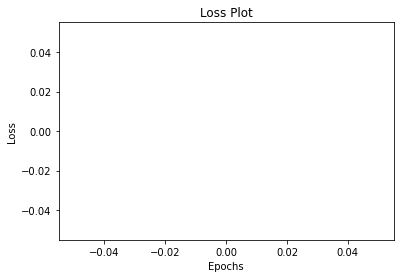

In [24]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [25]:
def evaluate(image):
    
    #hidden = model.reset_state(batch_size=1)
    #c = model.reset_state(batch_size=1)

    temp_input = tf.expand_dims(test_x_in, 0)
    #features = encoder(temp_input)
    #output_, [hidden, c], attention_weights = decoder(features, [hidden, c])
    predictions, _, attention_weights = model(temp_input)#, [hidden, c])
    attention_plot = attention_weights[:,:,0]#tf.reshape(attention_weights, (-1, )).numpy()
    predictions = tf.nn.softmax(predictions).numpy()
    result = [predictions[0]]

#     for i in range(max_length):
#         predictions, [hidden, c], attention_weights = decoder(features, [hidden, c])

#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
#         predictions = predictions.numpy()
#         if np.sum(predictions[0]) < 0.1:
#             break
            
#         result.append(predictions[0])

    #attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [26]:
import cv2
import os
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(6, 6))

    fname = os.path.basename(image)
    np.save(fname, attention_plot)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (10, 10))
        temp_att = cv2.GaussianBlur(temp_att, (3, 3), 0)
        ax = fig.add_subplot(len_result, 1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [27]:
# Sampling test indexes
# idx = random.sample(range(test_x.shape[0]), num_test_sample)


# # Test for Sampling data
# for idx_sample in range(num_test_sample):
#     result, attention_plot = evaluate(imgtest[idx_sample])

#     #print ('Real Caption:', real_caption)
#     #print ('Prediction Caption:', result)
#     plot_attention(imgtest[idx_sample], result, attention_plot)

In [28]:
# Sampling test indexes
idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap

num_correct = 0.
#import matplotlib.image as mpimg

# Test for Sampling data
for idx_sample in range(num_test_sample):
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],IMG_SIZE,IMG_SIZE,3]))
    #test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
    test_x_in = test_x_reshape[idx_sample,:,:,:]
    
    #hidden = model.reset_state(batch_size=1)
    #c = model.reset_state(batch_size=1)

    temp_input = tf.expand_dims(test_x_in, 0)
    #features = encoder(temp_input)
    #output_, [hidden, c], attention_weights = decoder(features, [hidden, c])
    output_,_, attention_weights = model(temp_input)#, [hidden, c])

    alpha_ = attention_weights[:,:,0].numpy()
    predictions = tf.nn.softmax(output_).numpy()
    #alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
    
    #alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx_sample,:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)  
#     print(np.max(alpha_resize), np.min(alpha_resize))
#     print(np.max(test_x), np.min(test_x))
#     print(predictions)

# Get labels for test samples
    y_test_pred = np.argmax(predictions[0][:])
    y_test_true = np.argmax(test_y[idx_sample, :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(alpha_resize, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(test_x_in, cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.
    
    #print(np.max(alpha_resize), np.min(alpha_resize))

# Show results 
#print(np.max(alpha_resize), np.min(alpha_resize))
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))

ValueError: Tensor's shape (3, 3, 1, 64) is not compatible with supplied shape (3, 3, 3, 64)

In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable)

In [ ]:
w = model.layers[1]
print(w)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class CustomModel(Model):
    def __init__(self, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.dense1 = Dense(5, activation='relu', )
        self.dense2 = Dense(10, activation='relu')
        self.dense3 = Dense(3, activation='softmax')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

my_custom_model = CustomModel(name='my_custom_model')

In [ ]:
my_custom_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])